# Gradient Descent Estimation

In [1]:
import torch
import numpy as np
import pandas as pd
import sys
import torch.nn as nn
sys.path += ["../src"]
from scipy.special import expit as sigmoid
from scipy.special import logit
import simulator_opinion_dynamics as sod
from initialize_model import EarlyStopping,RandomizeEpsilon,choose_optimizer
from importlib import reload
from time import time
from tqdm import tqdm
import estimation_with_edges_and_evidences as ewee

import matplotlib.pyplot as plt
import seaborn as sns

from initialize_model import EarlyStopping,RandomizeEpsilon,choose_optimizer
from estimation_with_edges_and_evidences import kappa_from_epsilon

import opinion_dynamics_models_estimation as oe

## Simple BC Model

In [182]:
class Simple_BC_Estimation(nn.Module):
    
    def __init__(self, parameters0, X, edges):
        
        super().__init__()
        
        epsilon0, rho = parameters0
        self.rho = rho
        u,v,s,t = uvst = sod.convert_edges_uvst(edges)
        self.diff_X = X[t,u] - X[t,v]
        theta = torch.tensor([logit(epsilon0)], requires_grad = True)
        self.theta = nn.Parameter(theta)
        
    def forward(self):
        epsilon = torch.sigmoid(self.theta)
        kappa = kappa_from_epsilon(epsilon, self.diff_X, self.rho)
        return kappa
    
    def neg_log_likelihood_function(kappa, s):
        
        return -(torch.sum(torch.log((kappa * s) + ((1 - kappa) * (1 - s)))))

In [183]:
def gradient_descent_simple_BC(X, edges, rho, num_epochs, epsilon0 = 0.25, optimizer_name = "adam",
                               lr = 0.05, patience = 10, min_delta = 1e-6, min_epochs = 20, hide_progress = True):
    u,v,s,t = uvst = sod.convert_edges_uvst(edges)
    
    model_class = Simple_BC_Estimation
    model = model_class((epsilon0, rho), X, edges)
    loss_function = model_class.neg_log_likelihood_function
    
    early_stopping = EarlyStopping(patience, min_delta, min_epochs)
    optimizer = choose_optimizer(optimizer_name, lr, model)
    
    history = {"epsilon": [epsilon0], "loss": []}
    
    t0 = time()
    for epoch in tqdm(range(num_epochs), disable = hide_progress):
        
        kappa = model()
        loss = loss_function(kappa, s)
        
        loss.backward()
        optimizer.step()
        
        history["epsilon"].append(sigmoid(model.theta.item()))
        history["loss"].append(loss.item())
        
        optimizer.zero_grad()
        
        early_stopping(history["epsilon"][-1], history["epsilon"][-2], epoch)
        if early_stopping.early_stop:
            break
            
    t1 = time()
    history["time"] = t1 - t0
    
    return history

In [184]:
patience1, min_delta1, min_epochs1 = 10, 10e-6, 50
lr1 = 0.005

In [185]:
N1,T1,edge_per_t1,evidences_per_t1 = 20, 500, 8, 16

epsilon1, mu1, rho1 = parameters1 = 0.12, 0.2, 70

epsilon01 = 0.25

BC_simulator1 = sod.BC_simulator()
BC_simulator1.intialize_simulator(N1,T1,edge_per_t1)

X1, edges1 = BC_simulator1.simulate_trajectory(parameters1)

u1,v1,s1,t1 = uvst1 = sod.convert_edges_uvst(edges1)
s1 = s1.to(torch.float32)

In [186]:
history = gradient_descent_simple_BC(X1, edges1, rho1, 200)

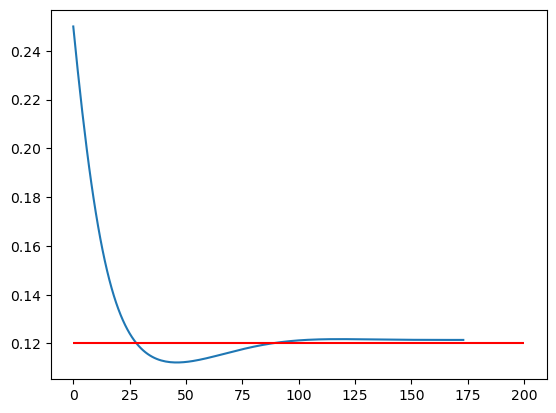

In [187]:
plt.plot(history["epsilon"])
plt.hlines(y = epsilon1, xmin = 0, xmax = 200, colors = "red")

In [188]:
model_class1 = Simple_BC_Estimation
model1 = model_class1((0.25, rho1), X1, edges1)
loss_function1 = model_class1.neg_log_likelihood_function

early_stopping1 = EarlyStopping(patience1, min_delta1, min_epochs1)
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.001)

history = {"epsilon": [0.25], "loss": []}

In [ ]:
t0 = time()
for epoch in tqdm(range(800)):
    
    kappa1 = model1()
    loss = loss_function1(kappa1, s1)
    
    loss.backward()
    optimizer1.step()
    
    history["epsilon"].append(sigmoid(model1.theta.item()))
    history["loss"].append(loss.item())
    
    optimizer1.zero_grad()
    
    early_stopping1(history["epsilon"][-1], history["epsilon"][-2], epoch)
    if early_stopping1.early_stop:
        break

t1 = time()

In [ ]:
t1 - t0

In [ ]:
plt.plot(history["epsilon"])

## BC Model with positive observation

In [ ]:
class BC_Observe_positive_Estimation(nn.Module):
    
    def __init__(self, parameters0, X, edges, sample_pairs = 50):
        
        super().__init__()
        
        epsilon0, rho = parameters0
        self.rho = rho
        uvst = sod.convert_edges_uvst(edges)
        u,v,s,t = uvst[:, uvst[2,:] == 1]
        self.X = X
        self.diff_X = X[t,u] - X[t,v]
        theta = torch.tensor([logit(epsilon0)], requires_grad = True)
        self.theta = nn.Parameter(theta)
        
        _, self.edge_per_t, _ = edges.size()
        self.T, self.N = X.size()
        self.sample_pairs = sample_pairs
        self.n_negative_interactions = self.edge_per_t - edges.sum(axis = 1)[:,2]
        
    def forward(self):
        epsilon = torch.sigmoid(self.theta)
        kappa_pos = kappa_from_epsilon(epsilon, self.diff_X, self.rho)
        
        u_sample, v_sample = torch.tensor((np.random.rand((self.T - 1) * self.sample_pairs, self.N).argpartition(2,axis = 1)[:,:2]).T)
        u_sample, v_sample = u_sample.reshape(self.sample_pairs, self.T-1), v_sample.reshape(self.sample_pairs, self.T-1)
        diff_sample_X = (torch.gather(self.X, 1, u_sample.T) - torch.gather(self.X, 1, v_sample.T))
        kappa_neg = 1 - (kappa_from_epsilon(epsilon, diff_sample_X, self.rho)).mean(axis = 1)

        return kappa_pos, kappa_neg
    
    def neg_log_likelihood_function(kappa_pos, kappa_neg, n_negative_interactions):
        log_likelihood_observed = torch.sum(torch.log(kappa_pos))
        log_likelihood_non_observed = torch.sum(torch.log(kappa_neg) * n_negative_interactions)
        
        neg_tot_log_likelihood = - log_likelihood_observed - log_likelihood_non_observed
        
        return neg_tot_log_likelihood

In [ ]:
def gradient_descent_BC_observe_positive(X, edges, rho, num_epochs, sample_pairs = 50,
                                         epsilon0 = 0.25, optimizer_name = "adam",
                                         lr = 0.05, patience = 10, min_delta = 1e-6, 
                                         min_epochs = 20, hide_progress = True):
    u,v,s,t = uvst = sod.convert_edges_uvst(edges)
    
    model_class = BC_Observe_positive_Estimation
    model = model_class((epsilon0, rho), X, edges)
    loss_function = model_class.neg_log_likelihood_function
    
    early_stopping = EarlyStopping(patience, min_delta, min_epochs)
    optimizer = choose_optimizer(optimizer_name, lr, model)
    
    history = {"epsilon": [epsilon0], "loss": []}
    
    t0 = time()
    for epoch in tqdm(range(num_epochs), disable = hide_progress):
        
        kappa_pos, kappa_neg = model()
        loss = loss_function(kappa_pos, kappa_neg, model.n_negative_interactions)
        
        loss.backward()
        optimizer.step()
        
        history["epsilon"].append(sigmoid(model.theta.item()))
        history["loss"].append(loss.item())
        
        optimizer.zero_grad()
        
        early_stopping(history["epsilon"][-1], history["epsilon"][-2], epoch)
        if early_stopping.early_stop:
            break
            
    t1 = time()
    history["time"] = t1 - t0
    
    return history

In [5]:
N1,T1,edge_per_t1,evidences_per_t1 = 30, 350, 8, 16

epsilon1, mu1, rho1 = parameters1 = 0.362, 0.4, 70

epsilon01 = 0.25

BC_simulator1 = sod.BC_simulator()
BC_simulator1.intialize_simulator(N1,T1,edge_per_t1)

X1, edges1 = BC_simulator1.simulate_trajectory(parameters1)

u1,v1,s1,t1 = uvst1 = sod.convert_edges_uvst(edges1)
s1 = s1.to(torch.float32)

In [6]:
model_class1 = BC_Observe_positive_Estimation
model1 = model_class1((epsilon01, rho1), X1, edges1)
loss_function1 = model_class1.neg_log_likelihood_function

early_stopping1 = EarlyStopping(patience1, min_delta1, min_epochs1)
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.005)

history = {"epsilon": [epsilon01], "loss": []}

NameError: name 'BC_Observe_positive_Estimation' is not defined

In [7]:
t0 = time()
for epoch in tqdm(range(800)):
    
    kappa_pos1, kappa_neg1 = model1()
    loss = model_class1.neg_log_likelihood_function(kappa_pos1, kappa_neg1, model1.n_negative_interactions)
    
    loss.backward()
    optimizer1.step()
    
    history["epsilon"].append(sigmoid(model1.theta.item()))
    history["loss"].append(loss.item())
    
    optimizer1.zero_grad()
    
    early_stopping1(history["epsilon"][-1], history["epsilon"][-2], epoch)
    if early_stopping1.early_stop:
        break

t1 = time()

  0%|                                                                                                         | 0/800 [00:00<?, ?it/s]


NameError: name 'model1' is not defined

In [8]:
t1 - t0

tensor([-1.6893e+09, -1.6893e+09, -1.6893e+09,  ..., -1.6893e+09,
        -1.6893e+09, -1.6893e+09])

In [9]:
plt.plot(history["epsilon"])

NameError: name 'history' is not defined

In [10]:
history["epsilon"][-1]

## BC with evidences on the opinion 

In [11]:
    def count_s_from_edge(e):
        e_unique = e.unique(dim = 0, return_counts = True)
        e_unique[0][:,2] = e_unique[0][:,2] * e_unique[1]
        e_sum_s = e_unique[0]
        return e_sum_s[e_sum_s[:,2] > 0]
    
    def edges_coo_mu(edges, mu, N):
        edges_count_s = [count_s_from_edge(edges[t]) for t in range(len(edges))]
        
        M = [torch.sparse_coo_tensor(indices = edges_count_s[t][:,:2].T, dtype = torch.float16,
                                     values = mu * edges_count_s[t][:,2], 
                                     size = [N, N]) for t in range(len(edges))]
        
        return M
    
    def X_from_X0_coo_edges(X0, M, T, N):
        X = torch.zeros([T, N], dtype = torch.float32)
        
        X[0] = X0
        for t in range(T - 1):
            updates = ((X[t] * M[t].to_dense()).sum(dim = 1) - (X[t] * M[t].to_dense().T).sum(dim = 0) +\
                       (X[t] * M[t].to_dense().T).sum(dim = 1) - (X[t] * M[t].to_dense()).sum(dim = 0))
            X[t+1] = X[t] + updates
        
        return X
        


In [48]:
def kappa_from_epsilon(epsilon, diff_X, rho):
    
    return torch.sigmoid(rho * (epsilon - torch.abs(diff_X)))

In [213]:
class BC_evidence_X_Estimation(nn.Module):
    
    def __init__(self, parameters0, X, edges, evidences):
        
        super().__init__()
        
        epsilon0, mu, rho = parameters0
        self.rho = rho
        self.mu = mu
        
        self.u,self.v,self.s,self.t = uvst = sod.convert_edges_uvst(edges)

        self.X = X
        self.diff_X = X[self.t,self.u] - X[self.t,self.v]
        _, self.edge_per_t, _ = edges.size()
        self.T, self.N = X.size()
        
        self.M = edges_coo_mu(edges, mu, self.N)
        
        self.evidences_per_t = len(evidences[0][0])

        self.evidences_indices = torch.cat([evidences[k][0][None,:] for k in range(len(evidences))], dim = 0) #tensor with the indices of the users of which we know the evidence
        self.evidences_opinions = torch.cat([evidences[k][1][None,:] for k in range(len(evidences))], dim = 0).reshape(self.T * self.evidences_per_t).to(torch.float32) #only the evidences of these users
        self.evideneces = evidences
        
        X0 = torch.rand(self.N, dtype = torch.float32, requires_grad = True) # random initialization of the opinions
        self.logit_X0 = nn.Parameter(torch.logit(X0))   #define the parameters of the model
        
        theta = torch.tensor([logit(epsilon0)], requires_grad = True)
        self.theta = nn.Parameter(theta)
        
        
    def forward(self):
        epsilon = torch.sigmoid(self.theta)
        X0 = torch.sigmoid(self.logit_X0)   #at each step clip X0 in the interval [0,1]
        X = X_from_X0_coo_edges(X0, self.M, self.T, self.N)
        
        diff_X = X[self.t,self.u] - X[self.t, self.v] 
        kappa = kappa_from_epsilon(epsilon, diff_X, self.rho) # compute probability of interaction with current estimate of epsilon
        
        return X, kappa
    
    
    def neg_log_likelihood_function(kappa, s, evidences_indices, evidences_opinions, evidences_per_t, X, minibatch_size):
        T, _ = X.shape
        
        sigmoid_kappa = kappa#torch.sigmoid(kappa)
        loss_edges = -torch.sum(torch.log(s * sigmoid_kappa + (1 - s) * (1 - sigmoid_kappa)))
        
        real_opinions = torch.cat([X[t, evidences_indices[t]] for t in range(T)])
        
        loss_evidences = -torch.sum(torch.log(evidences_opinions * real_opinions + (1 - evidences_opinions) * (1 - real_opinions)))
        
        return loss_edges + loss_evidences
    
    def neg_log_likelihood_function_minibatch(kappa, s, evidences_indices, evidences_opinions, evidences_per_t, X, t_minibatch):
        T, _ = X.shape
        
        sigmoid_kappa = kappa#torch.sigmoid(kappa)
        loss_edges = -torch.sum(torch.log(s * sigmoid_kappa + (1 - s) * (1 - sigmoid_kappa))[t_minibatch])
        
        real_opinions = torch.cat([X[t, evidences_indices[t]] for t in range(T)])
        
        loss_evidences = -torch.sum(torch.log(evidences_opinions * real_opinions + (1 - evidences_opinions) * (1 - real_opinions))[t_minibatch])
        
        return loss_edges + loss_evidences

In [214]:
def gradient_descent_BC_evidence_X(X, edges, evidences, mu, rho, num_epochs,
                                   epsilon0 = 0.25, optimizer_name = "adam",
                                   lr = 0.05, patience = 10, min_delta = 1e-6, 
                                   min_epochs = 20, hide_progress = True, minibatch_size = 0):
    u,v,s,t = uvst = sod.convert_edges_uvst(edges)
    T,_ = X.shape
    
    model_class = BC_evidence_X_Estimation
    model = model_class((epsilon0, mu, rho), X, edges, evidences)
    if minibatch_size == 0:
        loss_function = model_class.neg_log_likelihood_function
    if minibatch_size > 0:
        loss_function = model_class.neg_log_likelihood_function_minibatch
    
    early_stopping = EarlyStopping(patience, min_delta, min_epochs)
    optimizer = choose_optimizer(optimizer_name, lr, model)
    
    history = {"epsilon": [epsilon0], "loss": [], "X0": []}
    
    t0 = time()
    for epoch in tqdm(range(num_epochs), disable = hide_progress):
        t_minibatch = torch.randperm(T-1)[:minibatch_size]
        
        X_, kappa = model()
        loss = loss_function(kappa, model.s, model.evidences_indices, model.evidences_opinions, 
                             model.evidences_per_t, X_, t_minibatch)
        
        loss.backward()
        optimizer.step()
        
        history["X0"].append(sigmoid(model.logit_X0.detach()))
        history["epsilon"].append(sigmoid(model.theta.item()))
        history["loss"].append(loss.item())
        
        optimizer.zero_grad()
        
        early_stopping(history["epsilon"][-1], history["epsilon"][-2], epoch)
        if early_stopping.early_stop:
            break
            
    t1 = time()
    history["time"] = t1 - t0
    
    return history

In [271]:
N1,T1,edge_per_t1,evidences_per_t1 = 30, 150, 16, 16

epsilon1, mu1, rho1 = parameters1 = 0.452, 0.4, 16

epsilon01 = 0.25

BC_simulator1 = sod.BC_simulator()
BC_simulator1.intialize_simulator(N1,T1,edge_per_t1, evidences_per_t = evidences_per_t1)

X1, edges1, evidences1 = BC_simulator1.simulate_trajectory(parameters1)

u1,v1,s1,t1 = uvst1 = sod.convert_edges_uvst(edges1)
s1 = s1.to(torch.float32)

In [336]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [337]:
import opinion_dynamics_models_estimation as oe
from torcheval.metrics.functional import r2_score

In [345]:
history = oe.gradient_descent_BC_evidence_X(X1, edges1, evidences1, mu1, rho1, 200,
                                            epsilon0 = 0.25, optimizer_name = "RMSprop",
                                            lr = 0.05, patience = 10, min_delta = 1e-5, 
                                            min_epochs = 20, hide_progress = False, minibatch_size = 0)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.06it/s]


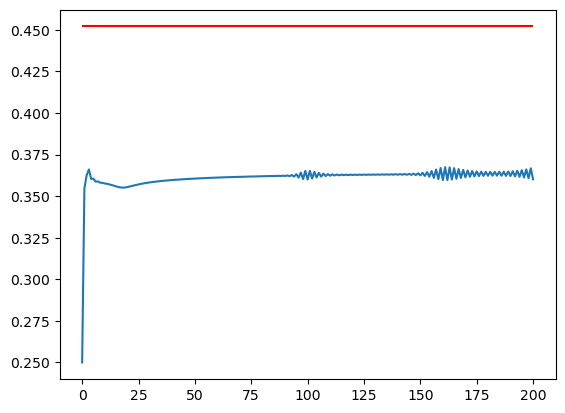

In [347]:
plt.plot(history["epsilon"])
plt.hlines(y = epsilon1, xmin = 0, xmax = 200, colors = "red")

In [340]:
history["time"]

17.85207200050354

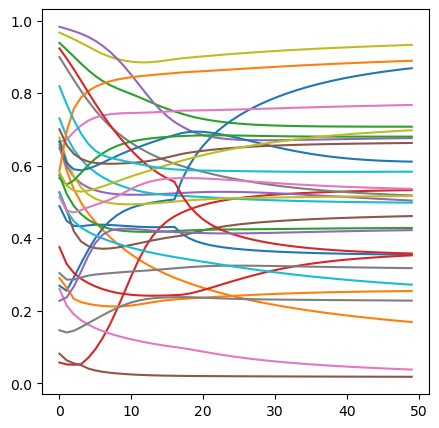

In [341]:
sod.print_opinion_trajectory(torch.cat([X0_[None,:] for X0_ in history["X0"]], dim = 0))

In [28]:
model_class1 = BC_evidence_X_Estimation
model1 = model_class1((epsilon01, mu1, rho1), X1, edges1, evidences1)
loss_function1 = model_class1.neg_log_likelihood_function

early_stopping1 = EarlyStopping(patience1, min_delta1, min_epochs1)
#optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.005)
optimizer1 = torch.optim.RMSprop(model1.parameters(), lr = 0.01)

history = {"epsilon": [epsilon01], "loss": [], "X0": []}

In [29]:
t0 = time()
for epoch in tqdm(range(800)):
    
    X_, kappa_ = model1()
    loss = model_class1.neg_log_likelihood_function(kappa_, model1.s, model1.evidences_indices, model1.evidences_opinions, model1.evidences_per_t, X_)
    
    loss.backward()
    optimizer1.step()
    
    history["X0"].append(sigmoid(model1.logit_X0.detach()))
    history["epsilon"].append(sigmoid(model1.theta.item()))
    history["loss"].append(loss.item())
    
    optimizer1.zero_grad()
    
    early_stopping1(history["epsilon"][-1], history["epsilon"][-2], epoch)
    if early_stopping1.early_stop:
        break

t1 = time()

 10%|█████████▌                                                                                      | 80/800 [00:04<00:41, 17.30it/s]


KeyboardInterrupt: 

In [30]:
t1 - t0

tensor([-1.6891e+09, -1.6891e+09, -1.6891e+09,  ..., -1.6891e+09,
        -1.6891e+09, -1.6891e+09])

<AxesSubplot:>

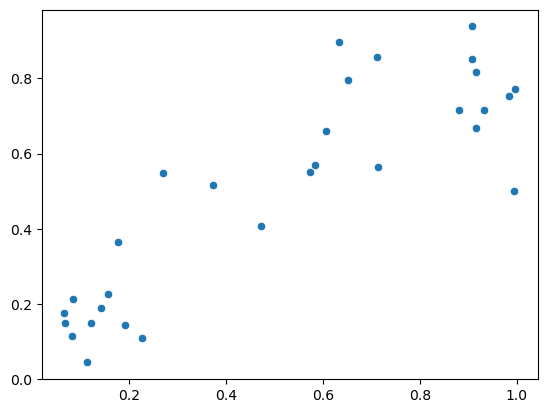

In [586]:
sns.scatterplot(x = X_[0].detach(), y = X1[0])

In [587]:
history["epsilon"][-1]

0.37719440802331794

In [32]:
import opinion_dynamics_models_estimation as oe

In [48]:
N1,T1,edge_per_t1,evidences_per_t1 = 100, 300, 8, 16

epsilon1, mu1, rho1 = parameters1 = 0.14, 0.12, 70

epsilon01 = 0.25

BC_simulator1 = sod.BC_simulator()
BC_simulator1.intialize_simulator(N1,T1,edge_per_t1, evidences_per_t = evidences_per_t1)

X1, edges1, evidences1 = BC_simulator1.simulate_trajectory(parameters1)

u1,v1,s1,t1 = uvst1 = sod.convert_edges_uvst(edges1)
s1 = s1.to(torch.float32)

In [50]:
history = oe.gradient_descent_BC_evidence_X(X1, edges1, evidences1, mu1, rho1, 300, lr = 0.04, optimizer_name = "RMSprop", hide_progress = False)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.06it/s]


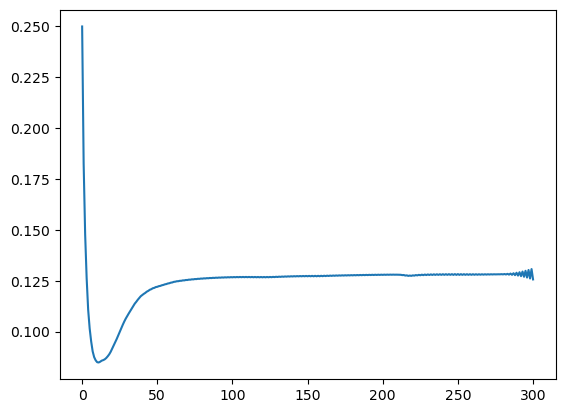

In [52]:
plt.plot(history["epsilon"])

<AxesSubplot:>

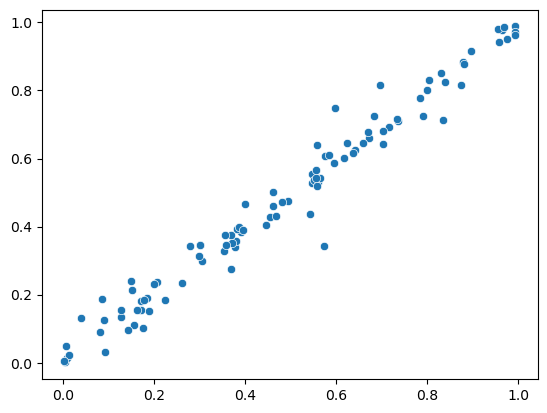

In [53]:
sns.scatterplot(x = history["X0"][-1], y = X1[0])

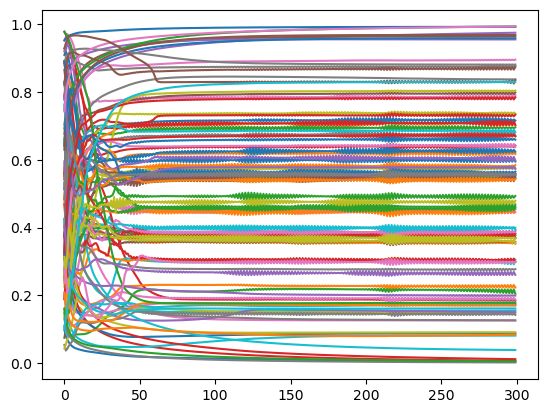

In [54]:
fig, axes = plt.subplots()

axes.plot(torch.cat([t[:, None] for t in history["X0"]], dim = 1).T.detach())

fig.show()

In [55]:
import cProfile

In [56]:
cProfile.run("oe.gradient_descent_BC_evidence_X(X1, edges1, evidences1, mu1, rho1, 50, optimizer_name = 'RMSprop', hide_progress = False)")



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.99it/s]

         125365 function calls (125049 primitive calls) in 7.308 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(repeat)
        1    0.003    0.003    7.308    7.308 <string>:1(<module>)
      299    0.000    0.000    0.000    0.000 _VF.py:26(__getattr__)
       50    0.001    0.000    4.870    0.097 __init__.py:103(backward)
       50    0.000    0.000    0.001    0.000 __init__.py:47(_make_grads)
       50    0.000    0.000    0.000    0.000 __init__.py:95(_tensor_or_tensors_to_tuple)
  598/299    0.001    0.000    0.019    0.000 _jit_internal.py:475(fn)
        1    0.000    0.000    0.000    0.000 _monitor.py:94(report)
      200    0.000    0.000    0.002    0.000 _ops.py:437(__call__)
      200    0.000    0.000    0.003    0.000 _tensor.py:33(wrapped)
       50    0.000    0.000    4.870    0.097 _tensor.py:429(backward)
      299    0.

### Backfire

In [222]:
epsilon_plus, epsilon_minus = 0.4, 0.6
mu_plus, mu_minus = 0.3, 0.1

rho = 16

parameters = [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho]
N, T, edge_per_t, evidences_per_t = 100, 256, 16, 16
X, edges, evidences = oe.simulate_BC(N = N, T = T, edge_per_t = edge_per_t, evidences_per_t = evidences_per_t, model = "backfire",
                                     parameters = parameters)

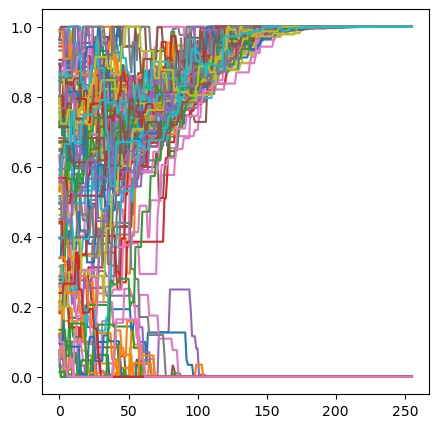

In [223]:
sod.print_opinion_trajectory(X)

In [280]:
history = oe.estimation_BC_model_from_data(X = X, edges = edges, 
                                           evidences = evidences, 
                                           parameters = parameters,
                                           optimizer_name = "adam", lr = 0.001, 
                                           X0_lr_scale = 1, num_epochs = 800, hide_progress = False,
                                           model_name = "BC_backfire", minibatch_size = 0,
                                           epsilon0_minus = 0.75, epsilon0_plus = 0.25
                                           ) 
print(history["time"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:45<00:00,  4.82it/s]

165.87252020835876


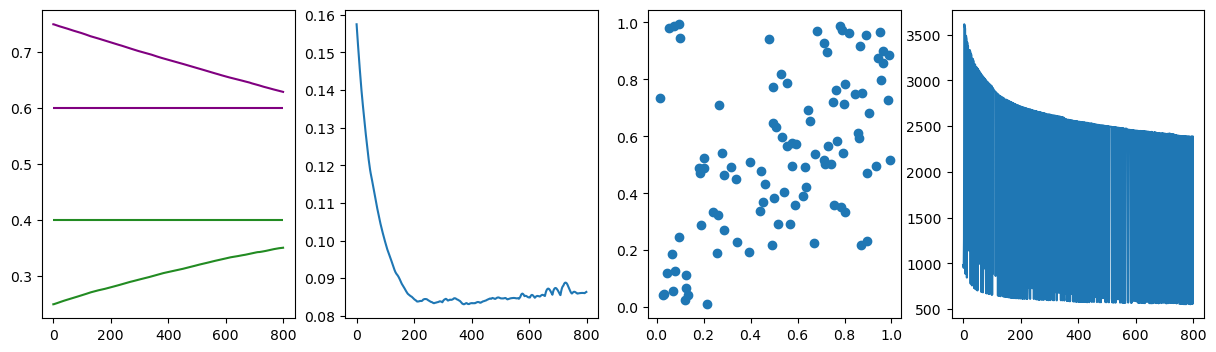

In [278]:
fig, axes = plt.subplots(ncols = 4, nrows = 1, figsize = (15, 4))

axes[0].plot(history["epsilon_plus"], color = "forestgreen")
axes[0].plot(history["epsilon_minus"], color = "purple")
axes[0].hlines(epsilon_plus, xmin = 0, xmax = len(history["loss"]), color = "forestgreen")
axes[0].hlines(epsilon_minus, xmin = 0, xmax = len(history["loss"]), color = "purple")

axes[1].plot([nn.functional.mse_loss(X[0], X0_).item() for X0_ in history["X0"]])

axes[2].plot(X[0], history["X0"][-1], "o")

axes[3].plot(history["loss"])

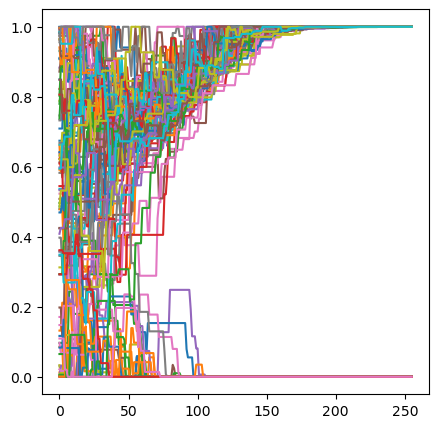

In [275]:
X_ = oe.X_from_X0_coo_edges_without_M(history["X0"][-1], edges, mu_plus, mu_minus, T, N)
sod.print_opinion_trajectory(X_)

In [91]:
def loss_function_edges(X, edges, evidences, epsilon_plus, epsilon_minus, rho):

    u,v, s_plus,s_minus, t = uvst = sod.convert_edges_uvst(edges)

    diff_X = X[t,u] - X[t, v] 
    kappa_plus = oe.kappa_from_epsilon(epsilon_plus, diff_X, rho)
    kappa_minus = oe.kappa_from_epsilon(epsilon_minus, diff_X, -rho) # compute probability of interaction with current 

    #evidences_indices = torch.cat([evidences[k][0][None,:] for k in range(len(evidences))], dim = 0) #tensor with the indices of the users of which we know the evidence
    #evidences_opinions = torch.cat([evidences[k][1][None,:] for k in range(len(evidences))], dim = 0).reshape(self.T * self.evidences_per_t).to(torch.float32) #only the evidences of these users
        
    

    loss_edges_plus = -torch.sum(torch.log(s_plus * kappa_plus + (1 - s_plus) * (1 - kappa_plus)))
    loss_edges_minus = -torch.sum(torch.log(s_minus * kappa_minus + (1 - s_minus) * (1 - kappa_minus)))
    
    #real_opinions = torch.cat([X[t, evidences_indices[t]] for t in range(T)])
    
    #loss_evidences = -torch.sum(torch.log(evidences_opinions * real_opinions + (1 - evidences_opinions) * (1 - real_opinions)))
    return loss_edges_plus, loss_edges_minus


In [228]:
epsilon_plus_grid = np.repeat(np.arange(0,1,0.01)[:,None], 100, axis = 1)
epsilon_minus_grid = np.repeat(np.arange(0,1,0.01)[None,:], 100, axis = 0)

In [261]:
loss_plus_grid = np.zeros([100,100])
loss_minus_grid = np.zeros([100,100])

for i in range(100):
    for j in range(100):
        loss_plus_grid[i,j], loss_minus_grid[i,j] = loss_function_edges(X, edges, evidences, epsilon_plus_grid[i,j], epsilon_minus_grid[i,j], rho)

In [262]:
loss_plus_grid_ = np.zeros([100,100])
loss_minus_grid_ = np.zeros([100,100])

for i in range(100):
    for j in range(100):
        loss_plus_grid_[i,j], loss_minus_grid_[i,j] = loss_function_edges(X_, edges, evidences, epsilon_plus_grid[i,j], epsilon_minus_grid[i,j], rho)

<AxesSubplot:>

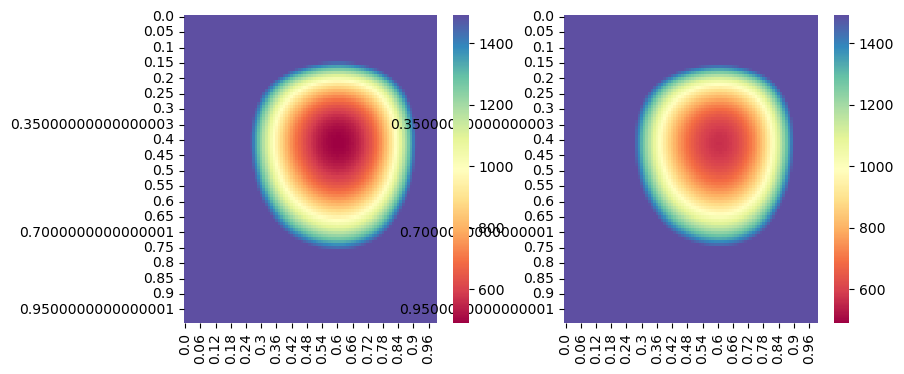

In [263]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (9, 4))

sns.heatmap(pd.DataFrame(loss_minus_grid+loss_plus_grid, columns = np.arange(0,1,0.01), 
                         index = np.arange(0,1,0.01)), vmin = (loss_minus_grid+loss_plus_grid).min(),
            vmax = (loss_minus_grid+loss_plus_grid).min() + 1000,
            cmap = "Spectral", ax = axes[0])

sns.heatmap(pd.DataFrame(loss_minus_grid_+loss_plus_grid_, columns = np.arange(0,1,0.01), 
                         index = np.arange(0,1,0.01)), vmin = (loss_minus_grid+loss_plus_grid).min(),
            vmax = (loss_minus_grid+loss_plus_grid).min() + 1000,
            cmap = "Spectral", ax = axes[1])

In [264]:
pd.DataFrame(loss_minus_grid+loss_plus_grid, columns = np.arange(0,1,0.01), 
                         index = np.arange(0,1,0.01)).stack().sort_values().head(5)

0.41  0.60    489.721695
      0.61    490.049942
0.40  0.60    490.139999
      0.61    490.468246
0.41  0.59    490.995087
dtype: float64

In [265]:
pd.DataFrame(loss_minus_grid_+loss_plus_grid_, columns = np.arange(0,1,0.01), 
                         index = np.arange(0,1,0.01)).stack().sort_values().head(5)

0.41  0.61    567.513489
      0.60    567.799469
0.40  0.61    568.260559
0.42  0.61    568.487671
0.40  0.60    568.546539
dtype: float64

In [266]:
history["epsilon_plus"][-1], history["epsilon_minus"][-1]

(0.44025880826249947, 0.6980607517019373)